In [65]:
import os
import caer
import canaro
import cv2 as cv
import gc

In [66]:
IMG_SIZE = (80,80)
channels = 1
char_path = r'../input/the-simpsons-characters-dataset/simpsons_dataset'

In [67]:
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path,char)))
    
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('simpsons_dataset', 42),
 ('agnes_skinner', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [68]:
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count += 1
    if count >= 10:
        break
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [69]:
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True)


[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 0.5870208740234375s
[INFO] At 1000 files
[INFO] 1454 files found in 0.11544346809387207s
[INFO] At 1000 files
[INFO] 1452 files found in 0.12708163261413574s
[INFO] At 1000 files
[INFO] 1354 files found in 0.08713483810424805s
[INFO] At 1000 files
[INFO] 1342 files found in 0.07846426963806152s
[INFO] At 1000 files
[INFO] 1291 files found in 0.060103416442871094s
[INFO] At 1000 files
[INFO] 1206 files found in 0.03086256980895996s
[INFO] At 1000 files
[INFO] 1194 files found in 0.022365331649780273s
[INFO] At 1000 files
[INFO] 1193 files found in 0.02196359634399414s
[INFO] At 1000 files
[INFO] 1079 files found in 0.0037386417388916016s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 0m 49s


In [70]:
len(train)

13811

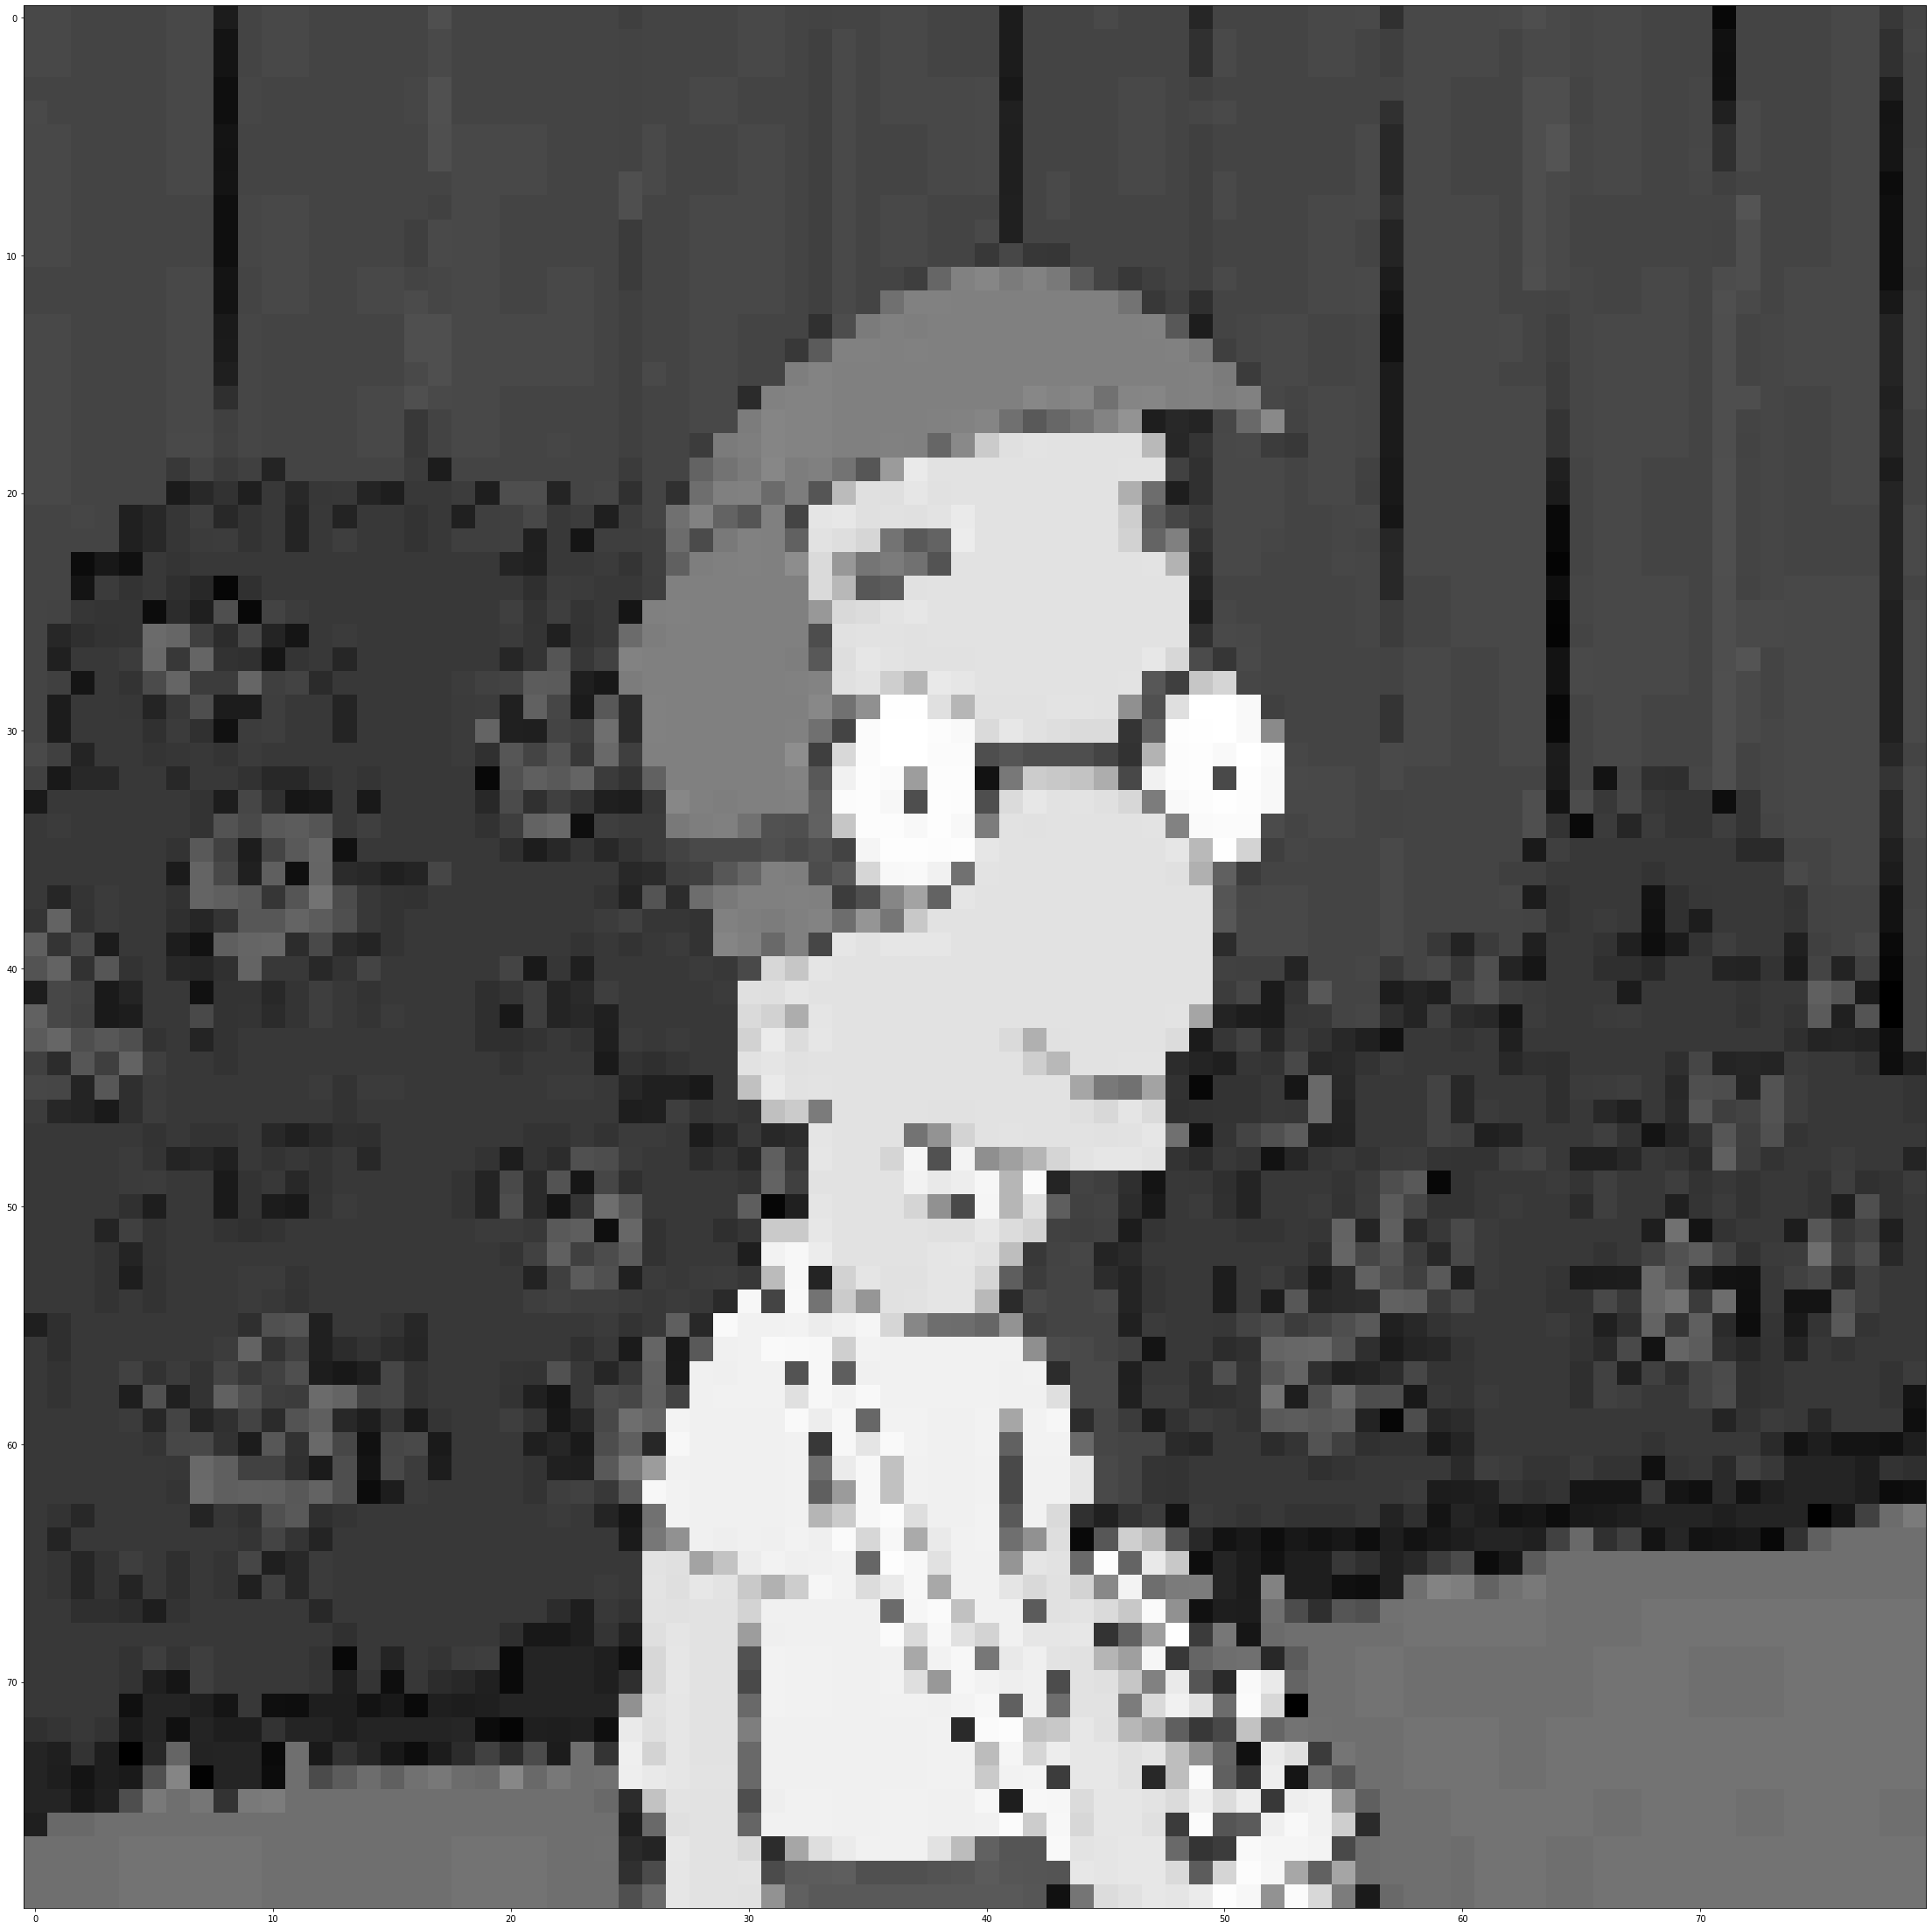

In [71]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,40))
plt.imshow(train[0][0], cmap='gray')
plt.show()

In [72]:
featureSet, labels = caer.sep_train(train, IMG_SIZE = IMG_SIZE)

In [73]:
from tensorflow.keras.utils import to_categorical
featureSet = caer.normalize(featureSet)
labels = to_categorical(labels, len(characters))

In [74]:
x_train, x_cal, y_train, y_val = caer.train_val_split(featureSet, labels, val_ratio=.2)

In [75]:
del train
del featureSet
del labels
gc.collect()

23

In [76]:
BATCH_SIZE = 32
EPOCHS = 10

In [77]:
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size = BATCH_SIZE)

In [78]:
model = canaro.models.createSimpsonsModel(IMG_SIZE = IMG_SIZE, channels=channels, output_dim=len(characters),
                                         loss='binary_crossentropy', decay=1e-6, learning_rate = 0.001,
                                         momentum = 0.9, nesterov=True)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [79]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 80, 80, 32)        320       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 78, 78, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 39, 39, 64)        18496     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 18, 18, 64)       

In [87]:
from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]

In [89]:
traning = model.fit(train_gen,
                   steps_per_epoch = len(x_train)//BATCH_SIZE,
                   epochs=EPOCHS,
                   validation_data=(x_cal,y_val),
                   validation_steps=len(y_val)//BATCH_SIZE,
                   callbacks = callbacks_list)

Epoch 1/10
345/345 [==============================] - 18s 29ms/step - loss: 0.3406 - accuracy: 0.1538 - val_loss: 0.3322 - val_accuracy: 0.1650
Epoch 2/10
345/345 [==============================] - 9s 26ms/step - loss: 0.3237 - accuracy: 0.1608
Epoch 3/10
345/345 [==============================] - 10s 28ms/step - loss: 0.3232 - accuracy: 0.1620
Epoch 4/10
345/345 [==============================] - 9s 25ms/step - loss: 0.3220 - accuracy: 0.1631
Epoch 5/10
345/345 [==============================] - 9s 26ms/step - loss: 0.3122 - accuracy: 0.2094
Epoch 6/10
345/345 [==============================] - 9s 26ms/step - loss: 0.3061 - accuracy: 0.2350
Epoch 7/10
345/345 [==============================] - 10s 28ms/step - loss: 0.3028 - accuracy: 0.2495
Epoch 8/10
345/345 [==============================] - 9s 26ms/step - loss: 0.3004 - accuracy: 0.2638
Epoch 9/10
345/345 [==============================] - 9s 26ms/step - loss: 0.2977 - accuracy: 0.2720
Epoch 10/10
345/345 [=========================

In [90]:
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

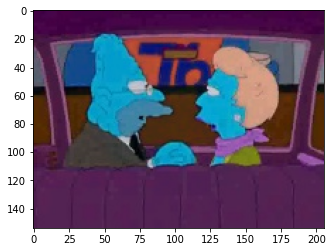

In [95]:
test_path = r'../input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/abraham_grampa_simpson_44.jpg'
img = cv.imread(test_path)

plt.imshow(img)
plt.show()

In [99]:
def prepare(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = cv.resize(img, IMG_SIZE)
    img = caer.reshape(img, IMG_SIZE, 1)
    return img

In [100]:
predictions = model.predict(prepare(img))

In [103]:
import numpy as np
print(characters[np.argmax(predictions[0])])

lisa_simpson
